# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [37]:
!pip install ipython-autotime
!pip install lightgbm

time: 3.62 s (started: 2021-04-27 07:43:00 +00:00)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%load_ext autotime

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

time: 614 ms (started: 2021-04-27 07:43:23 +00:00)


In [3]:
#sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

time: 1.21 ms (started: 2021-04-27 07:43:25 +00:00)


In [4]:
sns.set_style('whitegrid')

time: 620 µs (started: 2021-04-27 07:43:27 +00:00)


In [5]:
np.random.seed(42)

time: 432 µs (started: 2021-04-27 07:43:28 +00:00)


In [6]:
YEAR = 252
idx = pd.IndexSlice

time: 609 µs (started: 2021-04-27 07:43:28 +00:00)


In [7]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
if not path_data.exists():
    path_data.mkdir()
path_result = path_home / 'result'
if not path_result.exists():
    path_result.mkdir()

DATA_DIR = path_data
results_path = path_result

time: 1.04 ms (started: 2021-04-27 07:43:29 +00:00)


## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [ ]:
!gs cp gs://finance_data_bucket/data_stooq.zip
!unzip data_stooq.zip

In [8]:
data = (pd.read_csv(path_data / 'stooq_japan_equities.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])      
       )
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

We start with 941 tickers.

In [10]:
len(data.index.unique('ticker'))

941

time: 20.8 ms (started: 2021-04-24 00:28:08 +00:00)


### Select universe of 250 most-liquid stocks

We rank the stocks by their daily average dollar volume and select those with the 250 lowest average ranks and thus highest average volumes for the 2010-2017 period.

In [9]:
prices = (pd.read_csv(path_data / 'stooq_jp_tse_stocks_prices.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])    
          .loc[idx[:, '2010': '2017'], :]
         )

time: 15.8 s (started: 2021-04-27 07:44:12 +00:00)


In [11]:
dollar_vol = prices.close.mul(prices.volume)
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='ticker').mean().nsmallest(250).index

time: 3.31 s (started: 2021-04-27 07:45:05 +00:00)


## MultipleTimeSeriesCV

See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [13]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

time: 463 µs (started: 2021-04-24 00:28:29 +00:00)


For each fold, the train and test periods are separated by a `lookahead` number of periods and thus do not overlap:

In [14]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    if i == 3:
        break

Training: 2017-10-24-2019-11-25  (508 days) | Test: 2019-12-02-2019-12-30 (21 days)
Training: 2017-09-22-2019-10-24  (508 days) | Test: 2019-10-31-2019-11-29 (21 days)
Training: 2017-08-23-2019-09-20  (508 days) | Test: 2019-09-30-2019-10-30 (21 days)
Training: 2017-07-24-2019-08-21  (508 days) | Test: 2019-08-28-2019-09-27 (21 days)
time: 7.41 s (started: 2021-04-24 00:28:30 +00:00)


## Model Selection: Time Period and Horizon

For the model selection step, we restrict training and validation sets to the 2010-2017 period.

In [12]:
cv_data = data.loc[idx[universe, :'2017'], :]
tickers = cv_data.index.unique('ticker')
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 420082 entries, ('7203.JP', Timestamp('2010-01-04 00:00:00')) to ('4021.JP', Timestamp('2017-12-29 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ret_1            419868 non-null  float64
 1   ret_rel_perc_1   419868 non-null  float64
 2   ret_5            419012 non-null  float64
 3   ret_rel_perc_5   419012 non-null  float64
 4   ret_10           417942 non-null  float64
 5   ret_rel_perc_10  417942 non-null  float64
 6   ret_21           415588 non-null  float64
 7   ret_rel_perc_21  415588 non-null  float64
 8   ret_63           406600 non-null  float64
 9   ret_rel_perc_63  406600 non-null  float64
 10  PPO              414732 non-null  float64
 11  NATR             417086 non-null  float64
 12  RSI              417086 non-null  float64
 13  bbl              419226 non-null  float64
 14  bbu              419226 non-null  float64
 15  we

Persist the data to save some time when running another experiment:

In [24]:
cv_data.to_csv(path_data / 'stooq_japan_equities_cv_data.csv')
!zip -u data_stooq.zip data/stooq_japan_equities_cv_data.csv

time: 13.4 s (started: 2021-04-23 23:10:21 +00:00)


We're picking prediction horizons of 1, 5, 10 and 21 days:

In [16]:
lookaheads = [1, 5, 10, 21]

time: 398 µs (started: 2021-04-24 00:28:52 +00:00)


## Baseline: Linear Regression

Since it's quick to run and quite informative, we generate linear regression baseline predictions. See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [26]:
lr = LinearRegression(n_jobs=-1)

time: 459 µs (started: 2021-04-23 23:11:04 +00:00)


In [13]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

time: 6.32 ms (started: 2021-04-27 07:46:01 +00:00)


### CV Parameters

We set five different training lengths from 3 months to 5 years, and two test periods as follows:

In [29]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

time: 489 µs (started: 2021-04-23 23:12:09 +00:00)


Since linear regression has no hyperparameters, our CV parameters are the cartesian product of prediction horizon and train/test period lengths:

In [30]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

time: 838 µs (started: 2021-04-23 23:12:11 +00:00)


Now we iterate over these parameters and train/validate the linear regression model while capturing the information coefficient of the model predictions, measure both on a daily basis and for each complete fold:

In [31]:
lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 40/40 [04:54<00:00,  7.36s/it]

time: 4min 54s (started: 2021-04-23 23:12:18 +00:00)


In [32]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB
time: 11.1 ms (started: 2021-04-23 23:41:57 +00:00)


### Information Coefficient distribution by Lookahead

Convert the data to long `seaborn`-friendly format:

In [33]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB
time: 20.7 ms (started: 2021-04-23 23:42:13 +00:00)


Plot both IC measures for the various CV parameters:

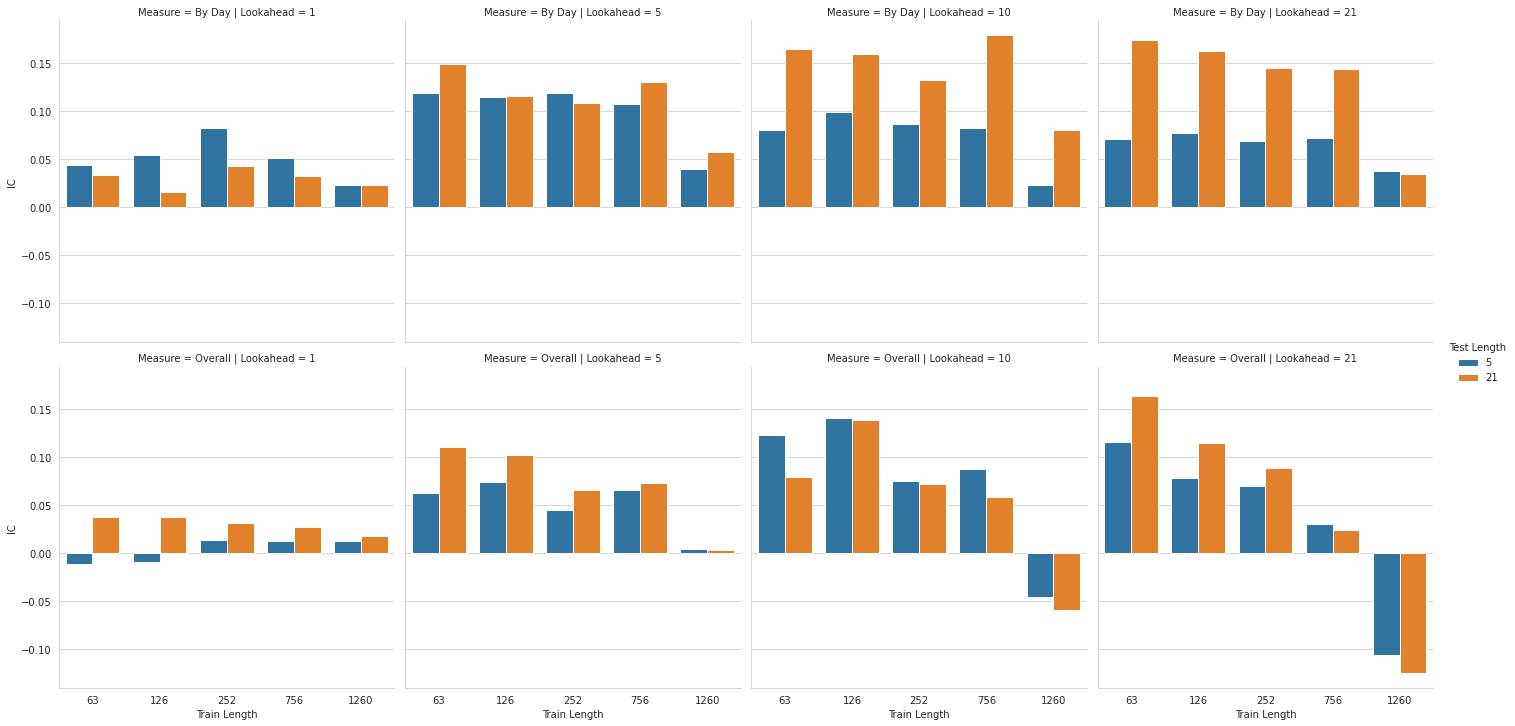

time: 1.94 s (started: 2021-04-23 23:42:18 +00:00)


In [34]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

Compare the distributions of each IC metric for the different prediction horizons:

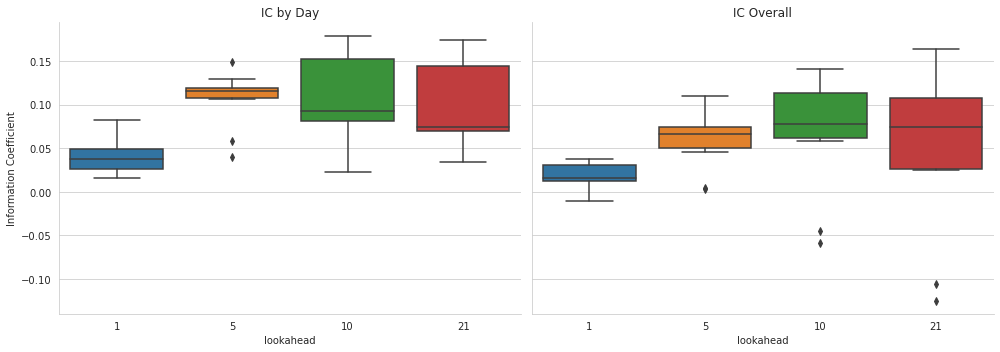

time: 512 ms (started: 2021-04-23 23:43:37 +00:00)


In [35]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

### Best Train/Test Period Lengths

Show the best train/test period settings for the four prediction horizons:

In [36]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
9,1,63,21,0.033615,0.037822
7,1,126,21,0.015814,0.037618
5,1,252,21,0.042732,0.031847
19,5,63,21,0.148540,0.110126
17,5,126,21,0.115812,0.101829
16,5,126,5,0.114283,0.074268
26,10,126,5,0.098941,0.140911
27,10,126,21,0.158797,0.138540
28,10,63,5,0.080264,0.122674
39,21,63,21,0.174340,0.163393


time: 33.2 ms (started: 2021-04-23 23:44:10 +00:00)


In [38]:
lr_metrics.to_csv(results_path / 'lin_reg_performance.csv', index=False)

time: 28.1 ms (started: 2021-04-23 23:45:05 +00:00)


## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

In [17]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

time: 505 µs (started: 2021-04-24 00:29:18 +00:00)


LightGBM base parameter settings that are independent of hyperparameter tuning:

In [18]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 8
time: 725 µs (started: 2021-04-24 00:29:20 +00:00)


### Hyperparameter Options

We run this experiment with different parameters for the bagging and feature fractions that determine the degree of randomization as well as the minimum number of samples for a split to control overfitting:

In [19]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [250, 500, 1000]

time: 476 µs (started: 2021-04-24 00:29:22 +00:00)


This gives us 3x2x3=18 parameter combinations:

In [20]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

time: 2.69 ms (started: 2021-04-24 00:29:27 +00:00)


#### Random Sample

To limit the running time, we can randomly sample a subset of the parameter combinations (here: 50%):

In [21]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9
time: 2.77 ms (started: 2021-04-24 00:29:29 +00:00)


We tune the number of trees by evaluating a fully grown forest for various smaller sizes:

In [22]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

time: 521 µs (started: 2021-04-24 00:29:31 +00:00)


### Train/Test Period Lenghts

As above for linear regression, we define a range of train/test period length:

#### Define parameters

In [23]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_lengths = 2 * YEAR

time: 527 µs (started: 2021-04-24 00:29:35 +00:00)


In [24]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

time: 450 µs (started: 2021-04-24 00:29:36 +00:00)


#### Random sample

Just as for the model parameters, we can randomly sample from the 5 x 2 = 8 training configurations (here: 50%):

In [25]:
sample_proportion = 0.5
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 10
CV Iterations: 90
time: 1.21 ms (started: 2021-04-24 00:29:38 +00:00)


### Categorical Variables

To leverage LightGBM's ability to handle categorical variables, we need to define them; we'll also `factorize` them so they are both integer-encoded and start at zero (optional, but otherwise throws a warning) as expected by LightGBM:

In [26]:
cv_data = (pd.read_csv(path_data / 'stooq_japan_equities_cv_data.csv' , parse_dates=['date'])
             .set_index(['ticker','date'])
             .sort_index(level=['ticker','date'])      
          )
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    cv_data[feature] = pd.factorize(cv_data[feature], sort=True)[0]

time: 99.1 ms (started: 2021-04-24 00:29:40 +00:00)


### Run Cross-Validation

Set up some helper variabels and storage locations to faciliate the CV process and result storage:

In [27]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

time: 5.25 ms (started: 2021-04-24 00:29:44 +00:00)


In [28]:
label_dict = dict(zip(lookaheads, labels))

time: 414 µs (started: 2021-04-24 00:29:45 +00:00)


In [29]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

time: 475 µs (started: 2021-04-24 00:29:46 +00:00)


Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [30]:
#for lookahead in lookaheads:
for lookahead in lookaheads[1:]:
    for train_length, test_length in test_params_:
        lgb_result = {}
        
        n_splits = int(val_lengths / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        #outcome_data = data.loc[:, features + [label]].dropna()
        outcome_data = cv_data.loc[:, features + [label]].dropna() #TODO

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                #lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                #lgb_test = lgb_data.subset(test_idx.tolist()).construct()
                lgb_train = lgb_data.subset(train_idx.tolist())
                lgb_test = lgb_data.subset(test_idx.tolist())

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  categorical_feature=categoricals, 
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            #predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)
            
        lgb_result['ic/' + key] = pd.DataFrame(ic, columns=ic_cols)
        lgb_result['daily_ic/' + key] = pd.concat(daily_ic)
        lgb_result['fi/' + key] = pd.concat(feature_importance)
        #lgb_result['predictions/' + key] = pd.concat(predictions)
        
    fname = f'tuning_stooq_jp_rf_{lookahead}'
    fname_pickle = fname + '.pickle'
    with open(path_result / fname_pickle, 'wb') as handle: # save to data dir
        pickle.dump(lgb_result, handle)

Lookahead:  1 | Train:  63 | Test: 21 | Params:   9
  0 | 00:01:40 | 50% | 75% |   250 |  2.01% |  1.14% |  0.99%
  1 | 00:03:30 | 50% | 75% |   500 |  1.90% |  1.23% |  1.38%
  2 | 00:05:02 | 75% | 75% | 1,000 |  1.97% |  1.29% |  1.12%
  3 | 00:06:27 | 50% | 95% | 1,000 |  2.37% |  1.29% |  1.32%
  4 | 00:07:60 | 50% | 95% |   250 |  2.62% |  0.92% |  0.85%
  5 | 00:09:30 | 95% | 75% |   500 |  2.07% |  0.86% |  0.99%
  6 | 00:10:59 | 95% | 95% |   500 |  2.59% |  0.82% |  0.08%
  7 | 00:12:27 | 95% | 95% |   250 |  2.16% |  0.74% |  0.17%
  8 | 00:13:57 | 75% | 95% | 1,000 |  2.44% |  1.18% |  0.44%
Lookahead:  1 | Train: 756 | Test:  5 | Params:   9
  0 | 00:20:19 | 50% | 75% |   250 |  1.56% |  0.98% |  0.75%
  1 | 00:40:47 | 50% | 75% |   500 |  1.67% |  1.08% |  0.97%
  2 | 00:58:25 | 75% | 75% | 1,000 |  1.93% |  1.14% |  1.15%
  3 | 01:20:09 | 50% | 95% | 1,000 |  2.11% |  0.91% |  0.56%
  4 | 01:40:38 | 50% | 95% |   250 |  1.94% |  1.01% |  0.91%
  5 | 01:58:11 | 95% | 75% |

KeyboardInterrupt: 

time: 13h 45min 43s (started: 2021-04-24 00:29:48 +00:00)


In [65]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_result) if isfile(join(path_result, f))]

lgb_result = {}
for y in ['daily_ic', 'fi', 'ic']:
    for x in onlyfiles:
        if x.startswith(y):
            #print(x, y, x.lstrip(y).rstrip('.csv'))
            #print(x, x.replace(y,'').rstrip('.csv'))
            
            #print(x, x.replace(y,'').rstrip('.csv').replace('_','/'))
            #print(x, y + x.replace(y,'').rstrip('.csv').replace('_','/'))
            key = y + x.replace(y,'').rstrip('.csv').replace('_','/')
            if y == 'daily_ic':
                lgb_result[key] = pd.read_csv(path_result / x, index_col=0, parse_dates=['date'])
            else:
                lgb_result[key] = pd.read_csv(path_result / x, index_col=0)

time: 308 ms (started: 2021-04-24 15:25:24 +00:00)


In [71]:
lgb_result.keys()
lgb_result['fi/1/756/21']

,count,mean,std,min,25%,50%,75%,max,bagging_fraction,feature_fraction,min_data_in_leaf
NATR,24.0,0.014463,0.006638,0.003306,0.010389,0.015217,0.018291,0.030741,0.50,0.75,250
PPO,24.0,0.015437,0.005177,0.004860,0.012034,0.015049,0.018089,0.025954,0.50,0.75,250
RSI,24.0,0.015121,0.006428,0.006182,0.009237,0.012477,0.020294,0.028948,0.50,0.75,250
bbl,24.0,0.018906,0.005840,0.010410,0.014527,0.019165,0.022755,0.037243,0.50,0.75,250
bbu,24.0,0.079815,0.018973,0.053604,0.062232,0.078851,0.093362,0.122148,0.50,0.75,250
...,...,...,...,...,...,...,...,...,...,...,...
ret_rel_perc_21,24.0,0.014729,0.014215,0.001176,0.002483,0.012273,0.022925,0.060076,0.75,0.95,1000
ret_rel_perc_5,24.0,0.014567,0.016612,0.000230,0.002375,0.009008,0.018609,0.057985,0.75,0.95,1000
ret_rel_perc_63,24.0,0.000245,0.000246,0.000000,0.000063,0.000168,0.000356,0.000821,0.75,0.95,1000
weekday,24.0,0.187753,0.041186,0.121439,0.152725,0.176222,0.223889,0.256808,0.75,0.95,1000


time: 19.1 ms (started: 2021-04-24 15:26:40 +00:00)


In [70]:
#m
#pd.concat(daily_ic)
pd.concat(feature_importance)

,count,mean,std,min,25%,50%,75%,max,bagging_fraction,feature_fraction,min_data_in_leaf
NATR,100.0,0.023057,0.009823,0.006364,0.013485,0.025922,0.030988,0.047284,0.5,0.75,250
PPO,100.0,0.028698,0.008243,0.012740,0.022865,0.028948,0.033283,0.055090,0.5,0.75,250
RSI,100.0,0.021911,0.007306,0.010028,0.017400,0.020482,0.026028,0.046474,0.5,0.75,250
bbl,100.0,0.006416,0.002643,0.001895,0.005019,0.005967,0.007613,0.014952,0.5,0.75,250
bbu,100.0,0.041481,0.020250,0.011852,0.026644,0.039383,0.053815,0.088888,0.5,0.75,250
month,100.0,0.422280,0.046706,0.298509,0.389589,0.432652,0.457422,0.501979,0.5,0.75,250
ret_1,100.0,0.013360,0.004541,0.005749,0.009436,0.012722,0.016570,0.022918,0.5,0.75,250
ret_10,100.0,0.067838,0.029192,0.026380,0.035232,0.074150,0.092900,0.124679,0.5,0.75,250
ret_21,100.0,0.063054,0.037353,0.009659,0.031675,0.060444,0.096421,0.123996,0.5,0.75,250
ret_5,100.0,0.049052,0.021916,0.007146,0.036698,0.048337,0.060050,0.110897,0.5,0.75,250


time: 20.5 ms (started: 2021-04-24 15:26:35 +00:00)


In [72]:
import pickle
fname = f'tuning_stooq_jp_rf_{lookaheads[0]}'
fname_pickle = fname + '.pickle'
with open(path_result / fname_pickle, 'wb') as handle: # save to data dir
    pickle.dump(lgb_result, handle)

time: 16 ms (started: 2021-04-24 15:28:46 +00:00)


## Analyse Cross-Validation Results

### Collect Data

We'll now combine the CV results that we stored separately for each fold (to avoid loosing results in case something goes wrong along the way):

In [10]:
### load result from bucket
!gsutil cp gs://finance_data_bucket/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

Copying gs://finance_data_bucket/stooq_jp_result.zip...
/ [1 files][  6.7 MiB/  6.7 MiB]                                                
Operation completed over 1 objects/6.7 MiB.                                      
Archive:  stooq_jp_result.zip
  inflating: result/lin_reg_performance.csv  
  inflating: result/tuning_stooq_jp_rf_1.pickle  
time: 1.92 s (started: 2021-04-25 00:08:52 +00:00)


In [9]:
# concat result
from os import listdir
from os.path import isfile, join
pfiles = [f for f in listdir(path_result) if isfile(join(path_result, f))]
pfiles = [f for f in pfiles if f.endswith('pickle')]

import pickle
lgb_result = {}
for fname_pickle in pfiles:
    with open(path_result / fname_pickle, 'rb') as handle:
        lgb_result.update(pickle.load(handle))

time: 94.7 ms (started: 2021-04-27 06:29:53 +00:00)


In [11]:
#lookaheads = [1, 5, 10, 21]
lookaheads = [1, 5, 10]

time: 455 µs (started: 2021-04-27 06:30:07 +00:00)


In [12]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

time: 458 µs (started: 2021-04-27 06:30:08 +00:00)


We'll look at the financial performance in the notebook `alphalens_signal_quality`.

In [13]:
daily_ic, ic = [], []
for t in lookaheads:
    print(t)
    store = lgb_result
    keys = [k[1:] for k in store.keys() if k.startswith(f'fi/{t}')]
    for key in keys:
        train_length, test_length = key.split('/')[2:]
        print(train_length, test_length)
        k = f'{t}/{train_length}/{test_length}'
        cols = {'t': t,
                'train_length': int(train_length),
                'test_length': int(test_length)}

        ic.append(pd.melt(store['ic/' + k]
                          .assign(**cols),
                          id_vars=id_vars[:-1],
                          value_name='ic',
                          var_name='rounds')
                  .apply(pd.to_numeric))

        df = store['daily_ic/' + k].assign(**cols).reset_index()
        daily_ic.append(pd.melt(df,
                                id_vars=id_vars,
                                value_name='daily_ic',
                                var_name='rounds')
                        .set_index('date')
                        .apply(pd.to_numeric)
                        .reset_index())            
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

1
756 21
756 5
126 5
252 21
126 21
63 21
1260 21
63 5
252 5
1260 5
63 21
756 5
1260 5
126 5
63 5
252 21
756 21
126 21
1260 21
252 5
5
63 21
756 5
1260 5
126 5
63 5
252 21
756 21
126 21
1260 21
252 5
10
63 21
756 5
1260 5
126 5
63 5
252 21
756 21
126 21
1260 21
252 5
time: 3.48 s (started: 2021-04-27 06:30:17 +00:00)


### Predictive Performance: CV Information Coefficient by Day

We first look at the daily IC, the metric we ultimately care about for a daily trading strategy. The best results for all prediction horizons are typically achieved with three years of training; the shorter horizons work better with 21 day testing period length. More regularization often improves the result but the impact of the bagging and feature fraction parameters are a little less clear cut and likely depend on other parameters.

In [14]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
147,1,63,5,0.95,0.95,250,200,0.013486
146,1,63,5,0.95,0.95,250,175,0.013454
148,1,63,5,0.95,0.95,250,225,0.013362
3180,5,756,21,0.95,0.75,500,25,0.022753
2900,5,756,5,0.50,0.75,500,25,0.021845
2901,5,756,5,0.50,0.75,500,50,0.021750
5265,10,1260,21,0.50,0.95,250,150,0.020888
5240,10,1260,21,0.50,0.75,500,25,0.019946
5285,10,1260,21,0.50,0.95,1000,150,0.019803


time: 901 ms (started: 2021-04-27 06:30:30 +00:00)


In [15]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 5400 non-null   int64  
 1   train_length      5400 non-null   int64  
 2   test_length       5400 non-null   int64  
 3   bagging_fraction  5400 non-null   float64
 4   feature_fraction  5400 non-null   float64
 5   min_data_in_leaf  5400 non-null   int64  
 6   rounds            5400 non-null   int64  
 7   ic                5400 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 337.6 KB
time: 19 ms (started: 2021-04-27 06:30:39 +00:00)


For a 1-day forecast horizon, over 75% of the predictions yield a positive daily IC; the same is true for 21 days which, unsurprisingly, also shows a wider range.

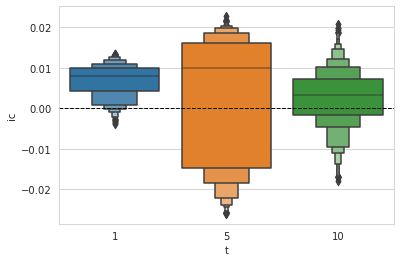

time: 240 ms (started: 2021-04-27 06:30:42 +00:00)


In [16]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

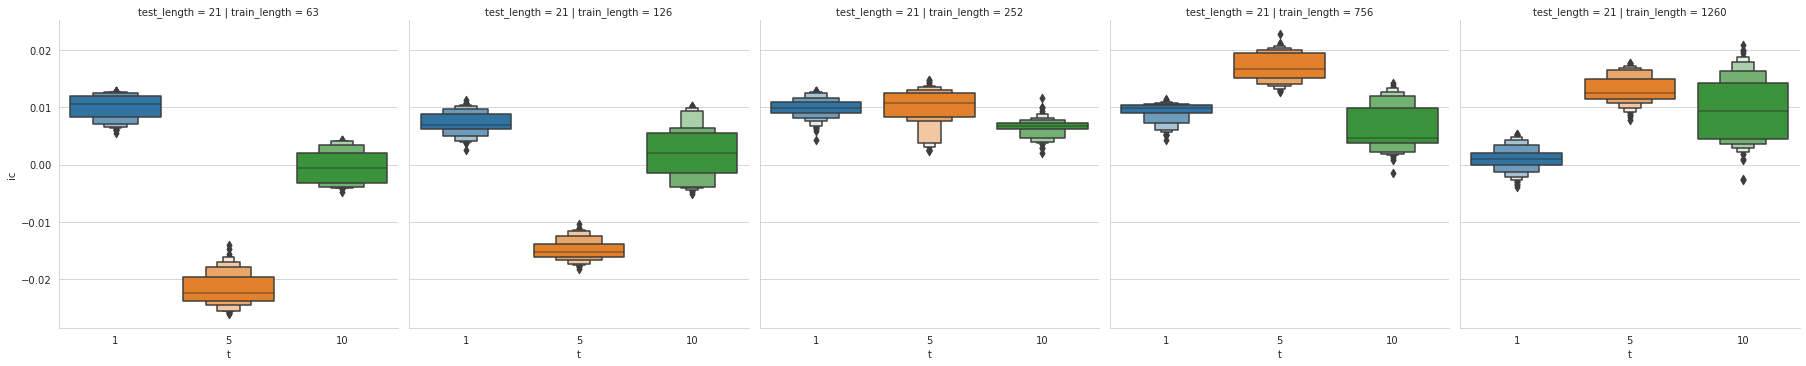

time: 2.03 s (started: 2021-04-27 06:37:03 +00:00)


In [20]:
#test_length = 5
test_length = 21
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == test_length)],
                kind='boxen')
g.savefig(results_path / f'daily_ic_test_{test_length:02}', dpi=300);

### HyperParameter Impact: Linear Regression

To get a better idea of how the various CV parameters impact the forecast quality, we can run a linear regression with the daily IC as outcome and the one-hot encoded hyperparameters as inputs:

In [51]:
lin_reg = {}
for t in [1, 5]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(results_path / f'lr_result_{t:02}.csv', index=False)

In [52]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Train\nLength', xy=(.09, -0.1), xytext=(.09, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Test\nLength', xy=(.23, -0.1), xytext=(.23, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Bagging\nFraction', xy=(.32, -0.1), xytext=(.32, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.7, lengthB=0.8', lw=1.0, color='black'))


    ax.annotate('Feature\nFraction', xy=(.44, -0.1), xytext=(.44, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=3.4, lengthB=1.0', lw=1.0, color='black'))
    

    ax.annotate('Min.\nSamples', xy=(.55, -0.1), xytext=(.55, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.0', lw=1.0, color='black'))    
    
    ax.annotate('Number of\nRounds', xy=(.8, -0.1), xytext=(.8, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=1.0', lw=1.0, color='black'))

The below plot shows the regression coefficient values and their confidence intervals. The intercept (not shown) has a small positive value and is statistically signifant; it captures the impact of the dropped categories (the smallest value for each parameter).

For 1-day forecasts, some but not all results are insightful: 21-day testing is better, and so is `min_samples_leaf` of 500 or 1,000. 100-200 trees seem to work best, but both shorter and longer training periods are better than intermediate values.

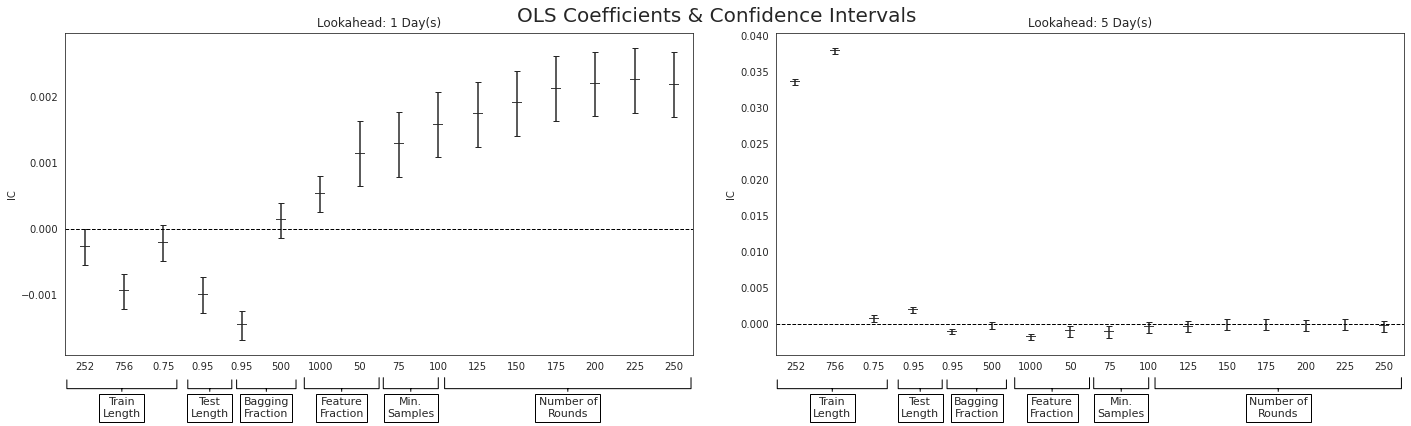

In [53]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes = axes.flatten()
    for i, t in enumerate([1, 5]):
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.92)

### Information Coefficient: Overall

We'll also take a look at the overall IC value, which is often reported but does not necessarily match the goal of a daily trading strategy that uses the model return predictions as well as the daily IC.

In [21]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      7200 non-null   int64  
 1   test_length       7200 non-null   int64  
 2   bagging_fraction  7200 non-null   float64
 3   feature_fraction  7200 non-null   float64
 4   min_data_in_leaf  7200 non-null   int64  
 5   t                 7200 non-null   int64  
 6   rounds            7200 non-null   int64  
 7   ic                7200 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 450.1 KB
time: 17.4 ms (started: 2021-04-27 06:37:28 +00:00)


#### Best Parameters

Directionally, and for shorter periods, similar hyperparameter settings work best (while the IC values are higher):

In [22]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                        
1  1628          1260            5              0.75              0.95   
   2168          1260            5              0.75              0.95   
   1680          1260            5              0.95              0.95   
5  5041          1260           21              0.50              0.75   
   5050          1260           21              0.50              0.75   
   5098          1260           21              0.50              0.95   
10 5594           756            5              0.95              0.75   
   6786           126           21              0.50              0.75   
   6787           126           21              0.50              0.75   

         min_data_in_leaf   t  rounds        ic  
t                                                
1  1628              1000   1      25  0.047854  
   2168              1000   1      25  0.047854  
   1680               500   1     175  0.045532  
5  5041               500   5      25  0.068586  
   5050               500   5      50  0.068092  
   5098               250   5     175  0.067691  
10 5594               500  10      50  0.065383  
   6786               250  10     375  0.064898  
   6787               500  10     375  0.064442

time: 31.7 ms (started: 2021-04-27 06:37:35 +00:00)


#### Visualiztion

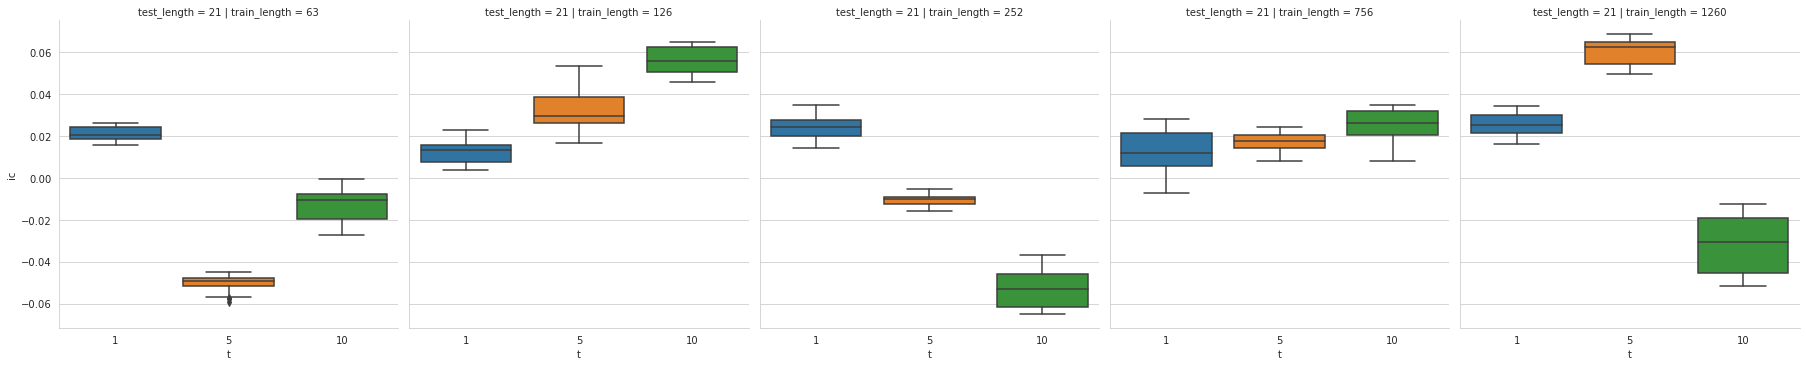

time: 1.17 s (started: 2021-04-27 06:37:40 +00:00)


In [23]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)],
                kind='box')

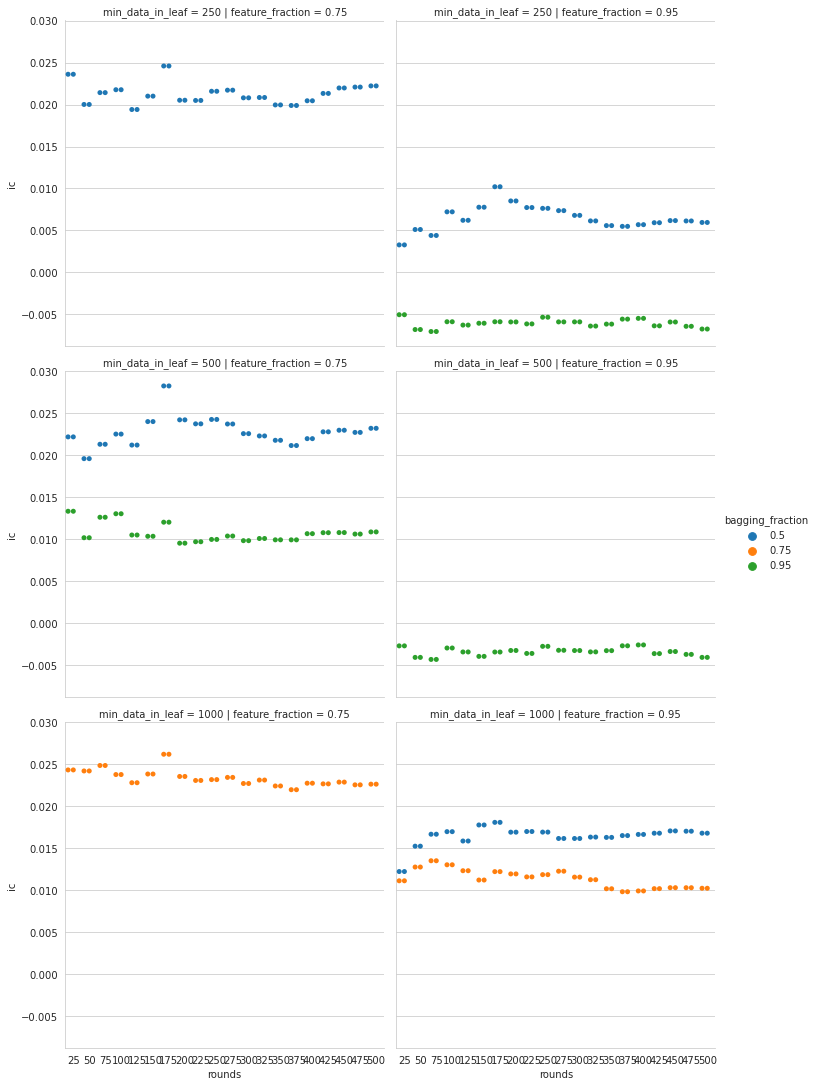

time: 10.9 s (started: 2021-04-27 06:38:26 +00:00)


In [24]:
t = 1
train_length = 756
test_length = 21
g = sns.catplot(x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm');

### Random Forest vs Linear Regression 

Let's compare the best-performing (in-sample) random forest models to our linear regression baseline:

In [25]:
lr_metrics = pd.read_csv(results_path / 'lin_reg_performance.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB
time: 21.2 ms (started: 2021-04-27 06:39:06 +00:00)


In [26]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 5400 non-null   int64  
 1   train_length      5400 non-null   int64  
 2   test_length       5400 non-null   int64  
 3   bagging_fraction  5400 non-null   float64
 4   feature_fraction  5400 non-null   float64
 5   min_data_in_leaf  5400 non-null   int64  
 6   rounds            5400 non-null   int64  
 7   ic                5400 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 337.6 KB
time: 19.3 ms (started: 2021-04-27 06:39:08 +00:00)


The results are mixed: for the shortest and longest horizons, the random forest outperforms (slightly for 1 day), while linear regression is competitive for the intermediate horizons:

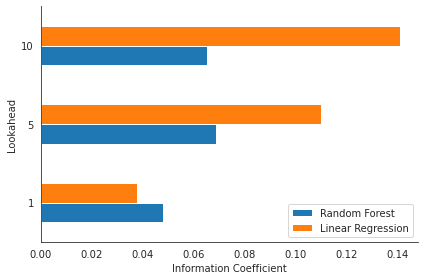

time: 303 ms (started: 2021-04-27 06:39:17 +00:00)


In [27]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();

## Generate predictions

To build and evaluate a trading strategy, we create predictions for the 2018-19 period using the 10 best models that we then ensemble:

In [54]:
!gsutil cp gs://finance_data_bucket/data_stooq.zip .
!unzip data_stooq.zip

Copying gs://finance_data_bucket/data_stooq.zip...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][651.8 MiB/651.8 MiB]                                                
Operation completed over 1 objects/651.8 MiB.                                    
Archive:  data_stooq.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
  inflating: data/stooq_us_nasdaq_etfs_prices.csv  
  inflating: data/stooq_us_nasdaq_etfs_tickers.csv  
  inflating: data/stooq_us_nasdaq_stocks_prices.csv  
  inflating: data/stooq_us_nasdaq_stocks_tickers.csv  
  inflating: data/stooq_us_nyse_etfs_prices.csv  
  inflating: data/stooq_us_nyse_etfs_tickers.csv  
  inflating: data/stooq_us_nyse_stocks_prices.csv  
  inflating: data/stooq_us_nyse_st

In [28]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

time: 436 µs (started: 2021-04-27 06:39:50 +00:00)


In [29]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

time: 672 µs (started: 2021-04-27 06:39:51 +00:00)


In [30]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 2
time: 829 µs (started: 2021-04-27 06:39:53 +00:00)


In [32]:
for lookahead in [1, 5, 10, 21]:
    if lookahead > 1: 
        continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_csv(path_data / 'stooq_japan_equities.csv', parse_dates=['date'])
              .set_index(['ticker','date'])
              .sort_index(level=['ticker','date']))
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(10):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(2 * YEAR / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        #params=params).construct()
                                        params=params)
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              categorical_feature=categoricals, 
                              verbose_eval=False)
        
            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(10):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_csv(path_result / f'test_{lookahead:02}.csv')


Lookahead: 01
	Position: 00
	Position: 01
	Position: 02
	Position: 03
	Position: 04
	Position: 05
	Position: 06
	Position: 07
	Position: 08
	Position: 09
time: 32min 46s (started: 2021-04-27 06:40:25 +00:00)


In [36]:
!zip -u stooq_jp_result.zip result/test_01.csv

  adding: result/test_01.csv (deflated 64%)
time: 10.2 s (started: 2021-04-27 07:27:07 +00:00)


In [33]:
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 470500 entries, ('1332.JP', Timestamp('2019-12-23 00:00:00')) to ('9990.JP', Timestamp('2017-12-15 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  470500 non-null  float64
 1   0       470500 non-null  float64
 2   1       470500 non-null  float64
 3   2       470500 non-null  float64
 4   3       470500 non-null  float64
 5   4       470500 non-null  float64
 6   5       470500 non-null  float64
 7   6       470500 non-null  float64
 8   7       470500 non-null  float64
 9   8       470500 non-null  float64
 10  9       470500 non-null  float64
dtypes: float64(11)
memory usage: 41.3+ MB
time: 39.4 ms (started: 2021-04-27 07:22:06 +00:00)


In [34]:
test_predictions.head()

y_test         0         1         2         3  \
ticker  date                                                           
1332.JP 2019-12-23  0.018612  0.005532  0.005587  0.005416  0.005364   
        2019-12-24 -0.013696 -0.001066 -0.001069 -0.001064 -0.001072   
        2019-12-25  0.009247 -0.001083 -0.001088 -0.001084 -0.001094   
        2019-12-26  0.001538 -0.001081 -0.001057 -0.001095 -0.001115   
        2019-12-27 -0.004590 -0.000579 -0.000562 -0.000609 -0.000671   

                           4         5         6         7         8         9  
ticker  date                                                                    
1332.JP 2019-12-23  0.005124  0.005311  0.005126  0.005067  0.005115  0.005084  
        2019-12-24 -0.000557 -0.000526 -0.000424 -0.000430 -0.000469 -0.000532  
        2019-12-25 -0.001260 -0.001204 -0.001107 -0.001101 -0.001187 -0.001212  
        2019-12-26  0.000621  0.000653  0.000798  0.000813  0.000672  0.000757  
        2019-12-27  0.001096  0.000901  0.001034  0.001039  0.001062  0.000819

time: 16.6 ms (started: 2021-04-27 07:24:18 +00:00)
